<a href="https://colab.research.google.com/github/mohamed-yassine-benkhadda/Cloud_removal/blob/main/Cloud%20removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✅ Task 1 : Image segmentation

## In this task we will build a model able to detect the occurrences of cloud in the given images and generate a mask for these clouds ☁

### Import libraries 🧰

In [1]:
import os
# from google.colab import drive
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from numpy import vstack
import torch.nn as nn
from torch.optim import Adam, Adagrad
from torch.nn import BCELoss
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.optim import SGD
from torch import Tensor
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
from PIL import Image
from skimage import filters
from skimage import exposure
import matplotlib.pyplot as plt
import re
import random
import math
from datetime import datetime

### Download data from Kaggle ⬇
The data we will use for this task is provided by kaggle : 
https://www.kaggle.com/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images

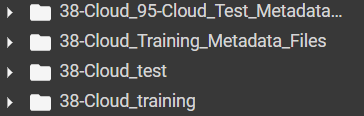

In [ ]:
# Connect to Google Drive
# drive.mount('/content/drive')

In [ ]:
# Locate the json file
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
# Download and unzip the dataset
# !kaggle datasets download -d sorour/38cloud-cloud-segmentation-in-satellite-images --unzip

In [ ]:
# !rm -d 38-Cloud_95-Cloud_Test_Metadata_Files

### Define the dataset class 📪

In [2]:
# define random seed
random.seed(42)

In [24]:
class _Data(Dataset):
  def __init__(self, files):
      self.files = files
      self.images = []
      for f in files:
        try:
          pic_red = cv2.imread(str(f["red"]))
          pic_red = cv2.cvtColor(pic_red, cv2.COLOR_BGR2GRAY)
#           pic_green = cv2.imread(str(f["green"]))
#           pic_green = cv2.cvtColor(pic_green, cv2.COLOR_BGR2GRAY)
#           pic_blue = cv2.imread(str(f["blue"]))
#           pic_blue = cv2.cvtColor(pic_blue, cv2.COLOR_BGR2GRAY)
          pic_gt = cv2.imread(str(f["gt"]))
          pic_gt = cv2.cvtColor(pic_gt, cv2.COLOR_BGR2GRAY)
          pic_gt = np.rot90(np.fliplr(pic_gt))
#           pic_nir = cv2.imread(str(f["nir"]))
#           pic_nir = cv2.cvtColor(pic_nir, cv2.COLOR_BGR2GRAY)
          pic_full = (np.dstack((pic_red))).astype(np.float32)
          self.images.append((pic_full,pic_gt))
        except:
          print("here")
      print("Done ✅")
  def __getitem__(self,i):
      return self.images[i]

  def __len__(self):
      return len(self.images)   

In [12]:
# Dataset Class
class CloudDataset(Dataset):
    def __init__(self, r_dir, base_dir,train=True,pytorch=True):
        super().__init__()
        self.files = []
        for f in os.listdir(base_dir/r_dir):
            if train:
              pic_gt = cv2.imread(str(base_dir/"train_gt_additional_to38cloud"/f.replace("red","gt")))
              pic_gt = cv2.cvtColor(pic_gt, cv2.COLOR_BGR2GRAY)
              to_tensor = transforms.ToTensor()
              t1 = to_tensor(pic_gt)
              ratio = t1.sum().numpy()
              if ratio/384**2 >=0.25 and ratio/384**2<=0.75:
                  self.files.append({
                      "red" : base_dir/"train_red_additional_to38cloud"/f,
                      "green" : base_dir/"train_green_additional_to38cloud"/f.replace("red","green"),
                      "blue" : base_dir/"train_blue_additional_to38cloud"/f.replace("red","blue"),
                      "nir" : base_dir/"train_nir_additional_to38cloud"/f.replace("red","nir"),
                      "gt" : base_dir/"train_gt_additional_to38cloud"/f.replace("red","gt"),
                  })
            else:
              self.files.append({
                  "red" : base_dir/"train_red_additional_to38cloud"/f,
                  "green" : base_dir/"train_green_additional_to38cloud"/f.replace("red","green"),
                  "blue" : base_dir/"train_blue_additional_to38cloud"/f.replace("red","blue"),
                  "nir" : base_dir/"train_nir_additional_to38cloud"/f.replace("red","nir"),
                  "gt" : base_dir/"train_gt_additional_to38cloud"/f.replace("red","gt"),
              })
        
    def split_train_test(self, ratio = 0.7):
        self.shuffle()
        elements = len(self.files)
        files = self.files[:math.ceil(elements * 0.5)]
        middle = int(len(files) * ratio)
        self.train_files = files[:middle]
        self.test_files = files[middle:]         
        return self.train_files,self.test_files
                                       
    def __len__(self):
        return len(self.files)

    def __getitem__(self,i):
      pic_red = cv2.imread(str(self.files[i]["red"]))
      pic_red = cv2.cvtColor(pic_red, cv2.COLOR_BGR2GRAY)
      pic_green = cv2.imread(str(self.files[i]["green"]))
      pic_green = cv2.cvtColor(pic_green, cv2.COLOR_BGR2GRAY)
      pic_blue = cv2.imread(str(self.files[i]["blue"]))
      pic_blue = cv2.cvtColor(pic_blue, cv2.COLOR_BGR2GRAY)
      print("here : ", str(self.files[i]["gt"]))
      pic_gt = cv2.imread(str(self.files[i]["gt"]))
      pic_gt = cv2.cvtColor(pic_gt, cv2.COLOR_BGR2GRAY)
      pic_nir = cv2.imread(str(self.files[i]["nir"]))
      pic_nir = cv2.cvtColor(pic_nir, cv2.COLOR_BGR2GRAY)
      pic = (np.dstack((pic_green,pic_blue,pic_red))) .astype(np.uint8)
      return pic,pic_gt

    def shuffle(self):
        return random.shuffle(self.files)

In [25]:
# Instantiate train and test data
base_train = Path('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud')
data = CloudDataset(base_dir=base_train,r_dir='train_red_additional_to38cloud')

In [26]:
len(data) 

2871

In [27]:
# Shuffle data
data.shuffle()

In [28]:
# Split data
train_data, test_data = data.split_train_test(ratio = 0.7)
del data

In [29]:
train_data = _Data(train_data)
test_data = _Data(test_data)

Done ✅
Done ✅


In [18]:
 l = (train_data[5][1].reshape(384,384,1)).flatten()

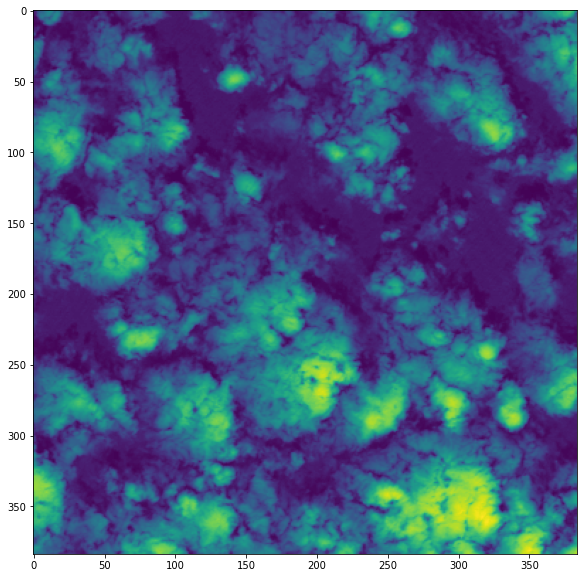

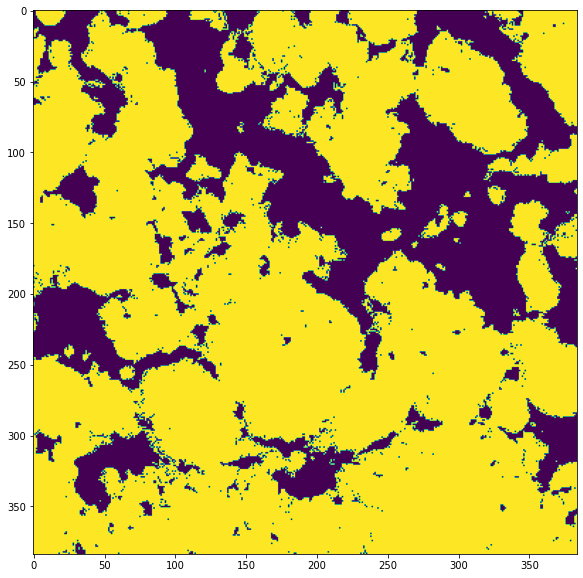

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(train_data[12][0].reshape(384,384,1))
plt.figure(figsize=(10,10))
plt.imshow(train_data[12][1].reshape(384,384,1)>.1)


# for i in range(384):
#     for j in range(384):
#         if (train_data[5][1].reshape(384,384,1)>=0.4)[i,j] == 1:
#             (train_data[5][0].reshape(384,384,3)[...,1])[i,j] = 0

        
# plt.figure(figsize=(10,10))
# plt.imshow(train_data[5][0].reshape(384,384,3)[...,1])
        

### Build the model 💻
For this task we will use U-Net model
![](https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png)


To build the model we will create Double convs objects and try to connect them so as to build the final model

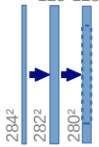

In [33]:
# Double Conv
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [34]:
# Build the Unet Model
class UNET(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        skip_connections = []
        x = x.resize_(1,1,384,384)
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [35]:
#Instantiate the model
unet = UNET()

### Train the model

In [36]:
len(train_data)

1005

In [39]:
loss_fn = nn.BCELoss()
optimizer = Adam(unet.parameters(), lr=0.001, weight_decay=0.0001)

In [40]:
learning_rate = 0.001
optimizer = Adam(unet.parameters(), lr=learning_rate, weight_decay=0.0001)
n_epochs = 50
loss = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet.to(device)
l = []
for epoch in range(n_epochs):
  running_loss = 0.0
  for (imgs, labels) in DataLoader(train_data,batch_size=15,shuffle=True):
    batch_size = imgs.shape[0]
    out = []
    for j in range(batch_size):
      labels = labels/255
      imgs = imgs.to("cuda:0")
      labels = labels.to("cuda:0")
      outputs = unet(imgs[j])
      out.append(outputs)
    pic = torch.stack(out)
    del out
    loss = loss_fn(pic.reshape(15,384,384).float(), labels.float())
    del pic
    del labels
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss
  l.append(float(running_loss))
  print("Epoch: %d, Loss: %f" % (epoch, float(running_loss)))

Epoch: 0, Loss: 13.840421
Epoch: 1, Loss: 3.686652
Epoch: 2, Loss: 1.671425
Epoch: 3, Loss: 0.949586
Epoch: 4, Loss: 0.609135
Epoch: 5, Loss: 0.432386
Epoch: 6, Loss: 0.320600
Epoch: 7, Loss: 0.249928
Epoch: 8, Loss: 0.200160
Epoch: 9, Loss: 0.163195
Epoch: 10, Loss: 0.138126
Epoch: 11, Loss: 0.116863
Epoch: 12, Loss: 0.102307
Epoch: 13, Loss: 0.089622
Epoch: 14, Loss: 0.080246
Epoch: 15, Loss: 0.070269
Epoch: 16, Loss: 0.064605
Epoch: 17, Loss: 0.058355
Epoch: 18, Loss: 0.060421
Epoch: 19, Loss: 0.049137
Epoch: 20, Loss: 0.046743
Epoch: 21, Loss: 0.042707
Epoch: 22, Loss: 0.040545
Epoch: 23, Loss: 0.038314
Epoch: 24, Loss: 0.036138
Epoch: 25, Loss: 0.073787
Epoch: 26, Loss: 0.061359
Epoch: 27, Loss: 0.038754
Epoch: 28, Loss: 0.033353
Epoch: 29, Loss: 0.030222
Epoch: 30, Loss: 0.027955
Epoch: 31, Loss: 0.026295
Epoch: 32, Loss: 0.024826
Epoch: 33, Loss: 0.023708
Epoch: 34, Loss: 0.023002
Epoch: 35, Loss: 0.022214
Epoch: 36, Loss: 0.021391
Epoch: 37, Loss: 0.020814
Epoch: 38, Loss: 0.02

In [79]:
tensor = torch.from_numpy(test_data[12][0])
tensor = tensor.cuda()
out = unet(tensor)
tensor2 = torch.from_numpy(test_data[12][1])
tensor2 = tensor2.cuda()

In [ ]:
24
189
42
96
12

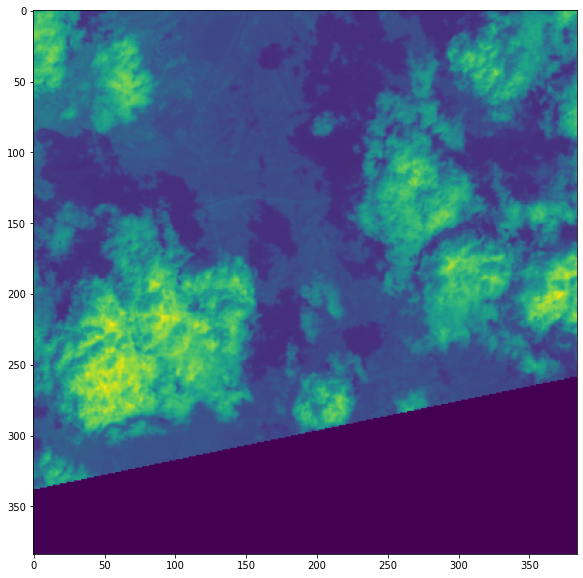

<Figure size 720x720 with 0 Axes>

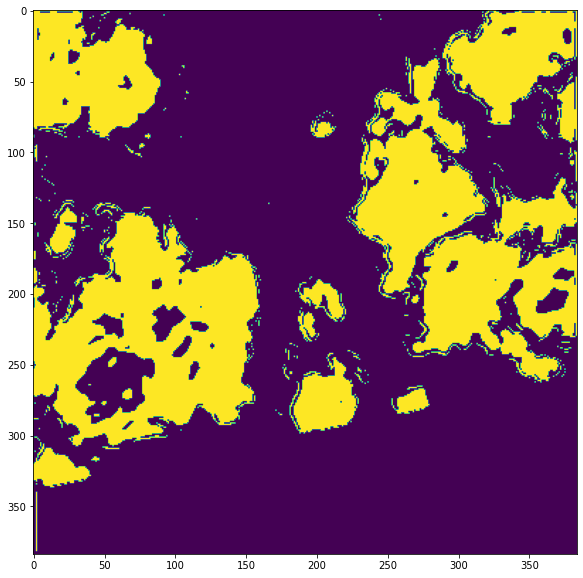

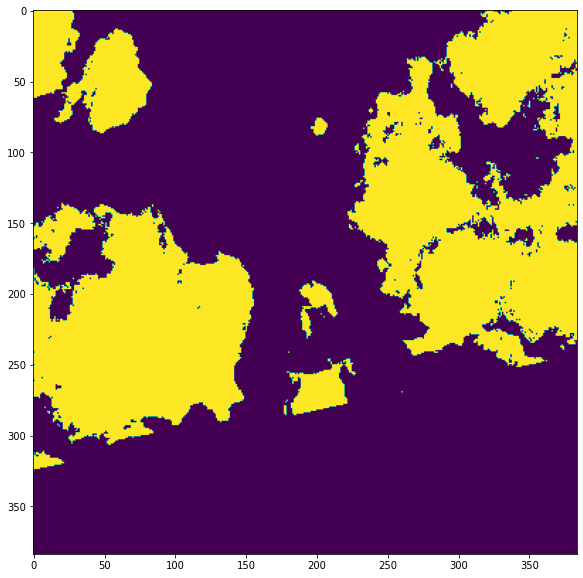

In [80]:
plt.figure(figsize=(10,10))
tensor_cv2 = tensor.reshape(384,384,1).cpu().detach().numpy()
plt.imshow(tensor_cv2)


plt.figure(figsize=(10,10))
out_cv2 = out.reshape(384,384).cpu().detach().numpy()
# out_cv2 = exposure.adjust_gamma(out_cv2, 2)
# plt.imshow(out_cv2)
# out_cv2 = filters.sobel(out_cv2)
# val1 = filters.threshold_isodata(out_cv2)
val2 = filters.threshold_mean(out_cv2)
val3 = filters.threshold_li(out_cv2)
val4 = filters.threshold_li(out_cv2)
val5 = filters.threshold_otsu(out_cv2)

pic_cv2 = (out_cv2>val2)*0.15 + (out_cv2>val3)*0.15 + (out_cv2>val4)*0.3 + (out_cv2>val5)*0.4

plt.figure(figsize=(10,10))
plt.imshow(pic_cv2>.2)

plt.figure(figsize=(10,10))
lab_cv2 = tensor2.reshape(384,384).cpu().detach().numpy()
plt.imshow(lab_cv2)
plt.show()

In [ ]:
a = []
for i in range(100000000000000000000):
  a.append(i)

In [81]:
((np.abs(((pic_cv2>=0.2))*255).all()- lab_cv2).sum())/384**2

0.3300442165798611

Reminder : not cloud 1, cloud 0

In [ ]:
plt.imshow(pic_cv2>0.6)

In [ ]:
s = torch.randint(1,10,(2,3))
s, s.sum().numpy()/255**2

In [ ]:
lab_cv2